# Fantasy Football 2020, Who Should I Draft?

With some machine learning I am looking to use 3 years of recent historical NFL data (with Yahoo Fantasy based points and ranks), so that I should be able to better prepare myself for my 2020 NFL Fantasy Football Draft. I have long followed resources like TheScore, ESPN, NFL Network and many other sports article outlets to help me better prepare for my drafts, and in the past I would create Excel docs with multiple sheets of reference data to help me make my choices. Since I understand how to create machine learning algorithms for better predictions I am putting it all to good use to help myself walk away with 1st place bragging rights for the next calendar year. 

First I am going to import a handful of packages that I will be using and applying to our data for our predictions, visualizations and data cleansing (so that I do not need to worry about it during my coding, I'll just do a bulk import here). Do keep in mind I may over-reach a bit here as I'm not sure the extent of what algorithms or exploration that I am going to do, so I'm going with a better safe than sorry approach here.

In [818]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import model_selection, metrics, datasets, feature_selection
from collections import defaultdict
from sklearn.model_selection import train_test_split
from seaborn import pairplot
import matplotlib.pyplot as plt
%pylab inline
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


There are 3 split datasets based on year; 2017, 2018 and 2019. I will only be bringing in RB, WR and TE stats to start as QBs typically aren't drafted until after round 8 in my yearly draft with my friends (exceptions usually fall to an Aaron Rodgers or the previous seasons upcoming Superstar, i.e Patty Mahomes or Lamar Jackson). Also note that I will not be pooling in DEF as those are taken in the final 2 rounds (general rule of thumb we all tend to go by). 

For reference I collected these sets from: https://www.footballdb.com/index.html

In [819]:
df1 = pd.read_csv('/Users/mitchellambing/desktop/Portfolio Predictions/Fantasy Football 2017 Stats - RB_WR_TE.csv', encoding='latin-1',index_col=0) 
df2 = pd.read_csv('/Users/mitchellambing/desktop/Portfolio Predictions/Fantasy Football 2018 Stats - RB_WR_TE.csv', encoding='latin-1',index_col=0) 
df3 = pd.read_csv('/Users/mitchellambing/desktop/Portfolio Predictions/Fantasy Football 2019 Stats - RB_WR_TE.csv', encoding='latin-1',index_col=0) 

In [820]:
df3.head()
# df3 is our newest set, 2019 data, so this is what I'll be using as my primary source for data exploration, 
# analysis and prediction

,Player,Position,Pts*,Att,Cmp,Yds,TD,Int,2Pt,Att.1,Yds.1,TD.1,2Pt.1,Rec,Yds.2,TD.2,2Pt.2,FL,TD.3
Rank,,,,,,,,,,,,,,,,,,,
1,Christian McCaffrey,RB,340,2,0,0,0,0,0,287,1387,15,1,116,1005,4,0,0,0
2,Derrick Henry,RB,266,0,0,0,0,0,0,303,1540,16,0,18,206,2,0,3,0
3,Aaron Jones,RB,255,0,0,0,0,0,0,236,1084,16,0,49,474,3,0,2,0
4,Ezekiel Elliott,RB,246,0,0,0,0,0,0,301,1357,12,0,54,420,2,0,2,0
5,Dalvin Cook,RB,229,0,0,0,0,0,0,250,1135,13,0,53,519,0,0,2,0


In [821]:
df3.columns

Index(['Player', 'Position', 'Pts*', 'Att', 'Cmp', 'Yds', 'TD', 'Int', '2Pt',
       'Att.1', 'Yds.1', 'TD.1', '2Pt.1', 'Rec', 'Yds.2', 'TD.2', '2Pt.2',
       'FL', 'TD.3'],
      dtype='object')

In [822]:
len(df3)

100

In [823]:
df3.shape

(100, 19)

In [824]:
df3.dtypes

Player      object
Position    object
Pts*         int64
Att          int64
Cmp          int64
Yds          int64
TD           int64
Int          int64
2Pt          int64
Att.1        int64
Yds.1        int64
TD.1         int64
2Pt.1        int64
Rec          int64
Yds.2        int64
TD.2         int64
2Pt.2        int64
FL           int64
TD.3         int64
dtype: object

Ok so its clear that we have your typical stats associated with each position, but because we're not using QBs right now all of the associated statistics for QBs will be removed (Att, Cmp etc). Alongside that I'll want to rename a handful of the remaining columns and then do a general check on the data to see how much cleaning up is required (since I already did a bit of data preprocessing in the CSVs the datasets shouldn't be too tough to work with). Another thought is that I'll need to amalgamate each season into one dataset possibly, and then distinguish each column with the associated year.

In [825]:
df1.drop(['Att', 'Cmp', 'Yds', 'TD', 'Int', '2Pt'], axis=1, inplace=True)
df2.drop(['Att', 'Cmp', 'Yds', 'TD', 'Int', '2Pt'], axis=1, inplace=True)
df3.drop(['Att', 'Cmp', 'Yds', 'TD', 'Int', '2Pt'], axis=1, inplace=True)

In [826]:
df1.rename({'Pts*': 'FantasyPts17','Att.1': 'RushingAtt17','Yds.1': 'RushingYards17','TD.1': 'RushingTD17','2Pt.1': 'Rushing2Pts17','Rec': 'Receptions17',
    'Yds.2': 'ReceivingYards17','TD.2': 'ReceivingTDs17','2Pt.2': 'Receiving2Pts17','FL': 'Fumbles17','TD.3':'FumbleTDs17'}, axis=1, inplace=True)

In [827]:
df2.rename({'Pts*': 'FantasyPts18','Att.1': 'RushingAtt18','Yds.1': 'RushingYards18','TD.1': 'RushingTD18','2Pt.1': 'Rushing2Pts18','Rec': 'Receptions18',
    'Yds.2': 'ReceivingYards18','TD.2': 'ReceivingTDs18','2Pt.2': 'Receiving2Pts18','FL': 'Fumbles18','TD.3':'FumbleTDs18'}, axis=1, inplace=True)

In [828]:
df3.rename({'Pts*': 'FantasyPts19','Att.1': 'RushingAtt19','Yds.1': 'RushingYards19','TD.1': 'RushingTD19','2Pt.1': 'Rushing2Pts19','Rec': 'Receptions19',
    'Yds.2': 'ReceivingYards19','TD.2': 'ReceivingTDs19','2Pt.2': 'Receiving2Pts19','FL': 'Fumbles19','TD.3':'FumbleTDs19'}, axis=1, inplace=True)

Now that we've cleaned some columns up, lets create 2 more additional columns for usage and fantasy points per game so we can gain a better understanding of the correlation between the two. This concept I derived from "fantasyfootballdatapros".

In [829]:
df3['Usage/GM'] = ((df3['RushingAtt19']/16) + (df3['Receptions19']/16))
df3['Usage/GM'] = df3['Usage/GM'].apply(lambda x: round(x, 2))

In [830]:
df3['FantasyPts/GM'] = (df3['FantasyPts19']/16)
df3['FantasyPts/GM'] = df3['FantasyPts/GM'].apply(lambda x: round(x, 2))

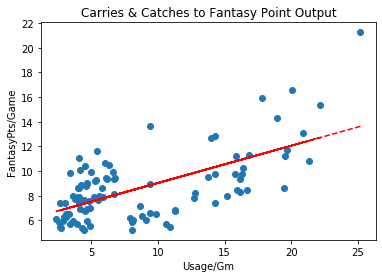

In [831]:
data = df3
x = df3['Usage/GM']
y = df3['FantasyPts/GM']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title('Carries & Catches to Fantasy Point Output')
plt.xlabel('Usage/Gm')
plt.ylabel('FantasyPts/Game')

plt.show()

Here we can now determine that one key factor that was theorized that helped determine output was usage/game, i.e the more carries and catches = more fantasy points. What is interesting is there is a large cluster between 2-8 carries+catches that range between 5-12 fantasy points/game. Might need to take a deeper dive into this and check other factors that could influence this. 

Next I'll compile a list of the players that fall into 3 fields that will help me determine who to target high, and sleeper picks for the late rounds. This will also yield a list of players that should probably be avoided based on last years production (until other factors come into play).

In [832]:
df_list = df3[['Player', 'Usage/GM', 'FantasyPts/GM']]

In [833]:
df_list['Low Use/High Production'] = (df3['Usage/GM'] < 7.00) & (df3['FantasyPts/GM'] > 7.00)
df_list['High Use/Low Production'] =  (df3['Usage/GM'] > 8.00) & (df3['FantasyPts/GM'] < 6.00)
df_list['High Use/High Production'] =  (df3['Usage/GM'] > 10.00) & (df3['FantasyPts/GM'] > 10.00)

In [834]:
high_value_players = (df_list.loc[df_list['High Use/High Production'].isin([True])])
high_value_players['Player']

Rank
1     Christian McCaffrey
2           Derrick Henry
3             Aaron Jones
4         Ezekiel Elliott
5             Dalvin Cook
7              Nick Chubb
8             Mark Ingram
9           Austin Ekeler
10           Chris Carson
12         Saquon Barkley
13            Todd Gurley
14              Joe Mixon
16      Leonard Fournette
20          Joshua Jacobs
Name: Player, dtype: object

In [835]:
potential_sleepers = (df_list.loc[df_list['Low Use/High Production'].isin([True])])
potential_sleepers['Player']

Rank
11         Chris Godwin
15       Kenny Golladay
17          Cooper Kupp
18          Julio Jones
19       DeVante Parker
21           Mike Evans
22      DeAndre Hopkins
23         Amari Cooper
24           A.J. Brown
29         Travis Kelce
30       Julian Edelman
31       Allen Robinson
33         Keenan Allen
34        Tyler Lockett
35        Jarvis Landry
36           D.J. Chark
37     Courtland Sutton
39         Stefon Diggs
40           John Brown
41           D.J. Moore
42       Michael Gallup
44         Mark Andrews
49         Robert Woods
50       Terry McLaurin
51        George Kittle
53        Calvin Ridley
54           Tyler Boyd
55        Darren Waller
56         Marvin Jones
57        Davante Adams
59         D.K. Metcalf
60          Tyreek Hill
61         Deebo Samuel
62            Zach Ertz
63    Odell Beckham Jr.
64     Emmanuel Sanders
65       Darius Slayton
67           Jared Cook
Name: Player, dtype: object

In [836]:
potential_busts = (df_list.loc[df_list['High Use/Low Production'].isin([True])])
potential_busts['Player']

Rank
90     Jordan Howard
93     Peyton Barber
96     Royce Freeman
100     LeSean McCoy
Name: Player, dtype: object

Now that we've created these broad lists, I'd like to see is the names of players who had various pieces that could lead into a big decline in prodcution this year (or high risk high reward), which would be: RBs with less than 220 carries but more than 800 rushing yards, WRs with an average Y/R over 15.00, RBs with more than 850 rushing and 500 receiving yards, and lastly RBs with an average Y/A over 4.8. 

Now none of these are set in stone guides to follow, but they are great indicators to keep in mind when developing your draft board to understand who has a higher chance of being a bust based off YoY bust projections (some details taken from CBS, NBC and NFL Network draft bust projection details). 

https://www.pro-football-reference.com/years/2019/rushing.htm, 
https://www.pro-football-reference.com/years/2019/receiving.htm

In [837]:
df3['Yards/Rec'] = ((df3['ReceivingYards19']) / (df3['Receptions19']))
df3['Yards/Rec'] = df3['Yards/Rec'].apply(lambda x: round(x, 2))

In [838]:
df3['Yards/Rush'] = ((df3['RushingYards19']) / (df3['RushingAtt19']))
df3['Yards/Rush'] = df3['Yards/Rush'].apply(lambda x: round(x, 2))

In [839]:
df_list_2 = df3[['Player', 'RushingAtt19', 'RushingYards19', 'Yards/Rec', 'Yards/Rush', 'ReceivingYards19']]

In [840]:
df_list_2['RBs Low Carries/High Yards'] = (df3['RushingAtt19'] < 220) & (df3['RushingYards19'] > 800)
df_list_2['WRs High Y/R'] =  (df3['Yards/Rec'] > 15.00) & (df3['Position'] == 'WR')
df_list_2['RBS High Y/A'] =  (df3['Yards/Rush'] > 4.80) & (df3['Position'] == 'RB')
df_list_2['RBS High Rush/High Rec'] =  (df3['RushingYards19'] > 800.00) & (df3['ReceivingYards19'] > 400.00) | (df3['RushingTD19'] > 10) & (df3['ReceivingTDs19'] > 3)

Ok we've created our new columns, now lets check which players fall into each field!

In [841]:
low_carry_high_yards = (df_list_2.loc[df_list_2['RBs Low Carries/High Yards'].isin([True])])
low_carry_high_yards['Player']

Rank
8         Mark Ingram
12     Saquon Barkley
25      Miles Sanders
28       Kenyan Drake
66    Adrian Peterson
Name: Player, dtype: object

In [842]:
high_yards_per_catch = (df_list_2.loc[df_list_2['WRs High Y/R'].isin([True])])
high_yards_per_catch['Player']

Rank
11        Chris Godwin
15      Kenny Golladay
19      DeVante Parker
21          Mike Evans
23        Amari Cooper
24          A.J. Brown
37    Courtland Sutton
39        Stefon Diggs
42      Michael Gallup
50      Terry McLaurin
65      Darius Slayton
76       Mike Williams
80        Chris Conley
83    Breshad Perriman
87        Randall Cobb
89     Tyrell Williams
97    James Washington
Name: Player, dtype: object

In [843]:
high_yards_per_run = (df_list_2.loc[df_list_2['RBS High Y/A'].isin([True])])
high_yards_per_run['Player']

Rank
1     Christian McCaffrey
2           Derrick Henry
7              Nick Chubb
8             Mark Ingram
28           Kenyan Drake
38         Raheem Mostert
73       Devin Singletary
82           Duke Johnson
Name: Player, dtype: object

In [844]:
high_reward_players = (df_list_2.loc[df_list_2['RBS High Rush/High Rec'].isin([True])])
high_reward_players['Player']

Rank
1     Christian McCaffrey
3             Aaron Jones
4         Ezekiel Elliott
5             Dalvin Cook
12         Saquon Barkley
16      Leonard Fournette
25          Miles Sanders
Name: Player, dtype: object

### This is great, now we have compiled a few different sets to see which players fall into our:
1) High Value Players

2) Potential Sleepers

3) Potential Busts

4) Low Carry but High Yardage RBs

5) High Yards/Catch WRs (used to determine further analysis for whether it is sustainable YoY)

6) High Yards/Carry RBs (used to determine further analysis for whether it is sustainable YoY)

7) High Reward Players (High Rushing & Receiving Yards OR at least 10 Rushing TDs and 4 Receiving TDs)

This is all great preliminary work to help us distinguish the different player types for developing our draft board, and will come in very handy for determining who to select in rounds 4-6!

In [869]:
# We'll use this next little section to do positional differences, and check impact based on position
rb_set = df3[df3['Position'] == 'RB']
wr_set = df3[df3['Position'] == 'WR']
te_set = df3[df3['Position'] == 'TE']

In [846]:
print ('The Total Fantasy Points For RBs is:' + ' ' + str(sum(rb_set['FantasyPts19'])))
print ('The Total RBs Contributing Are:' + ' ' + str(len(rb_set)))

The Total Fantasy Points For RBs is: 6271
The Total RBs Contributing Are: 41


In [847]:
print ('The Total Fantasy Points For WRs is:' + ' ' + str(sum(wr_set['FantasyPts19'])))
print ('The Total WRs Contributing Are:' + ' ' + str(len(wr_set)))

The Total Fantasy Points For WRs is: 6428
The Total WRs Contributing Are: 50


In [848]:
print ('The Total Fantasy Points For TEs is:' + ' ' + str(sum(te_set['FantasyPts19'])))
print ('The Total TEs Contributing Are:' + ' ' + str(len(te_set)))

The Total Fantasy Points For TEs is: 1110
The Total TEs Contributing Are: 9


In [849]:
print ('The Average Fantasy Points Per RB is:' + ' ' + str(6271/41))
print ('The Average Fantasy Points Per WR is:' + ' ' + str(6428/50))
print ('The Average Fantasy Points Per TE is:' + ' ' + str(1110/9))

The Average Fantasy Points Per RB is: 152.9512195121951
The Average Fantasy Points Per WR is: 128.56
The Average Fantasy Points Per TE is: 123.33333333333333


What is good to note here is that RBs obviously present the strongest position towards fantasy output, but whats interesting is there were 9 more WRs in the Top 100 than RBs, so for quality late round picks look for a RB2 but also keep note of any WR2's available late rounds as well (if no RB2s don't sit for a RB3, take 2+ WR2s). 

Text(0.5, 0, 'Fantasy Points Total')

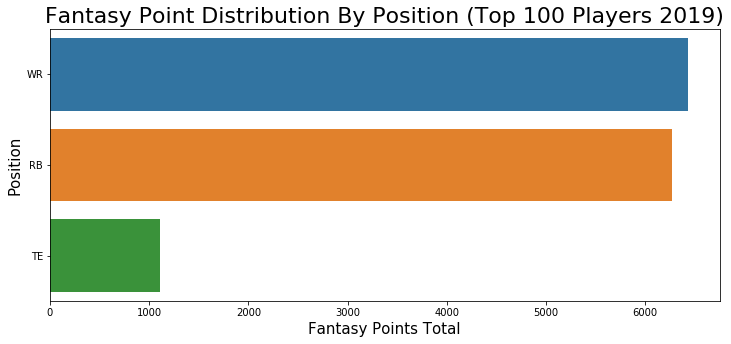

In [850]:
position_breakdown = df3.groupby(['Position']).sum().sort_values(['FantasyPts19'], ascending=False).reset_index()[:3]
position_breakdown['FantasyPts19'] = (position_breakdown['FantasyPts19'])
plt.figure(figsize=(12,5)) 
graph = sns.barplot(x=position_breakdown['FantasyPts19'], y=position_breakdown['Position'])
plt.title('Fantasy Point Distribution By Position (Top 100 Players 2019)', fontsize=22)
plt.ylabel('Position', fontsize=15)
plt.xlabel('Fantasy Points Total', fontsize=15)

Last part here I would like to bring in the 2017 and 2018 datasets to do a YoY analysis in change of fantasy points and production. I'm going to do a 2017 to 2018 check, then a 2018 to 2019 check.

In [851]:
df_join = pd.merge(df1, df2, how='inner', on='Player')
len(df_join)
# So there are 53 players who were in the Top 100 in 2017 also in the Top 100 2018

53

In [852]:
df_join_plot = df_join

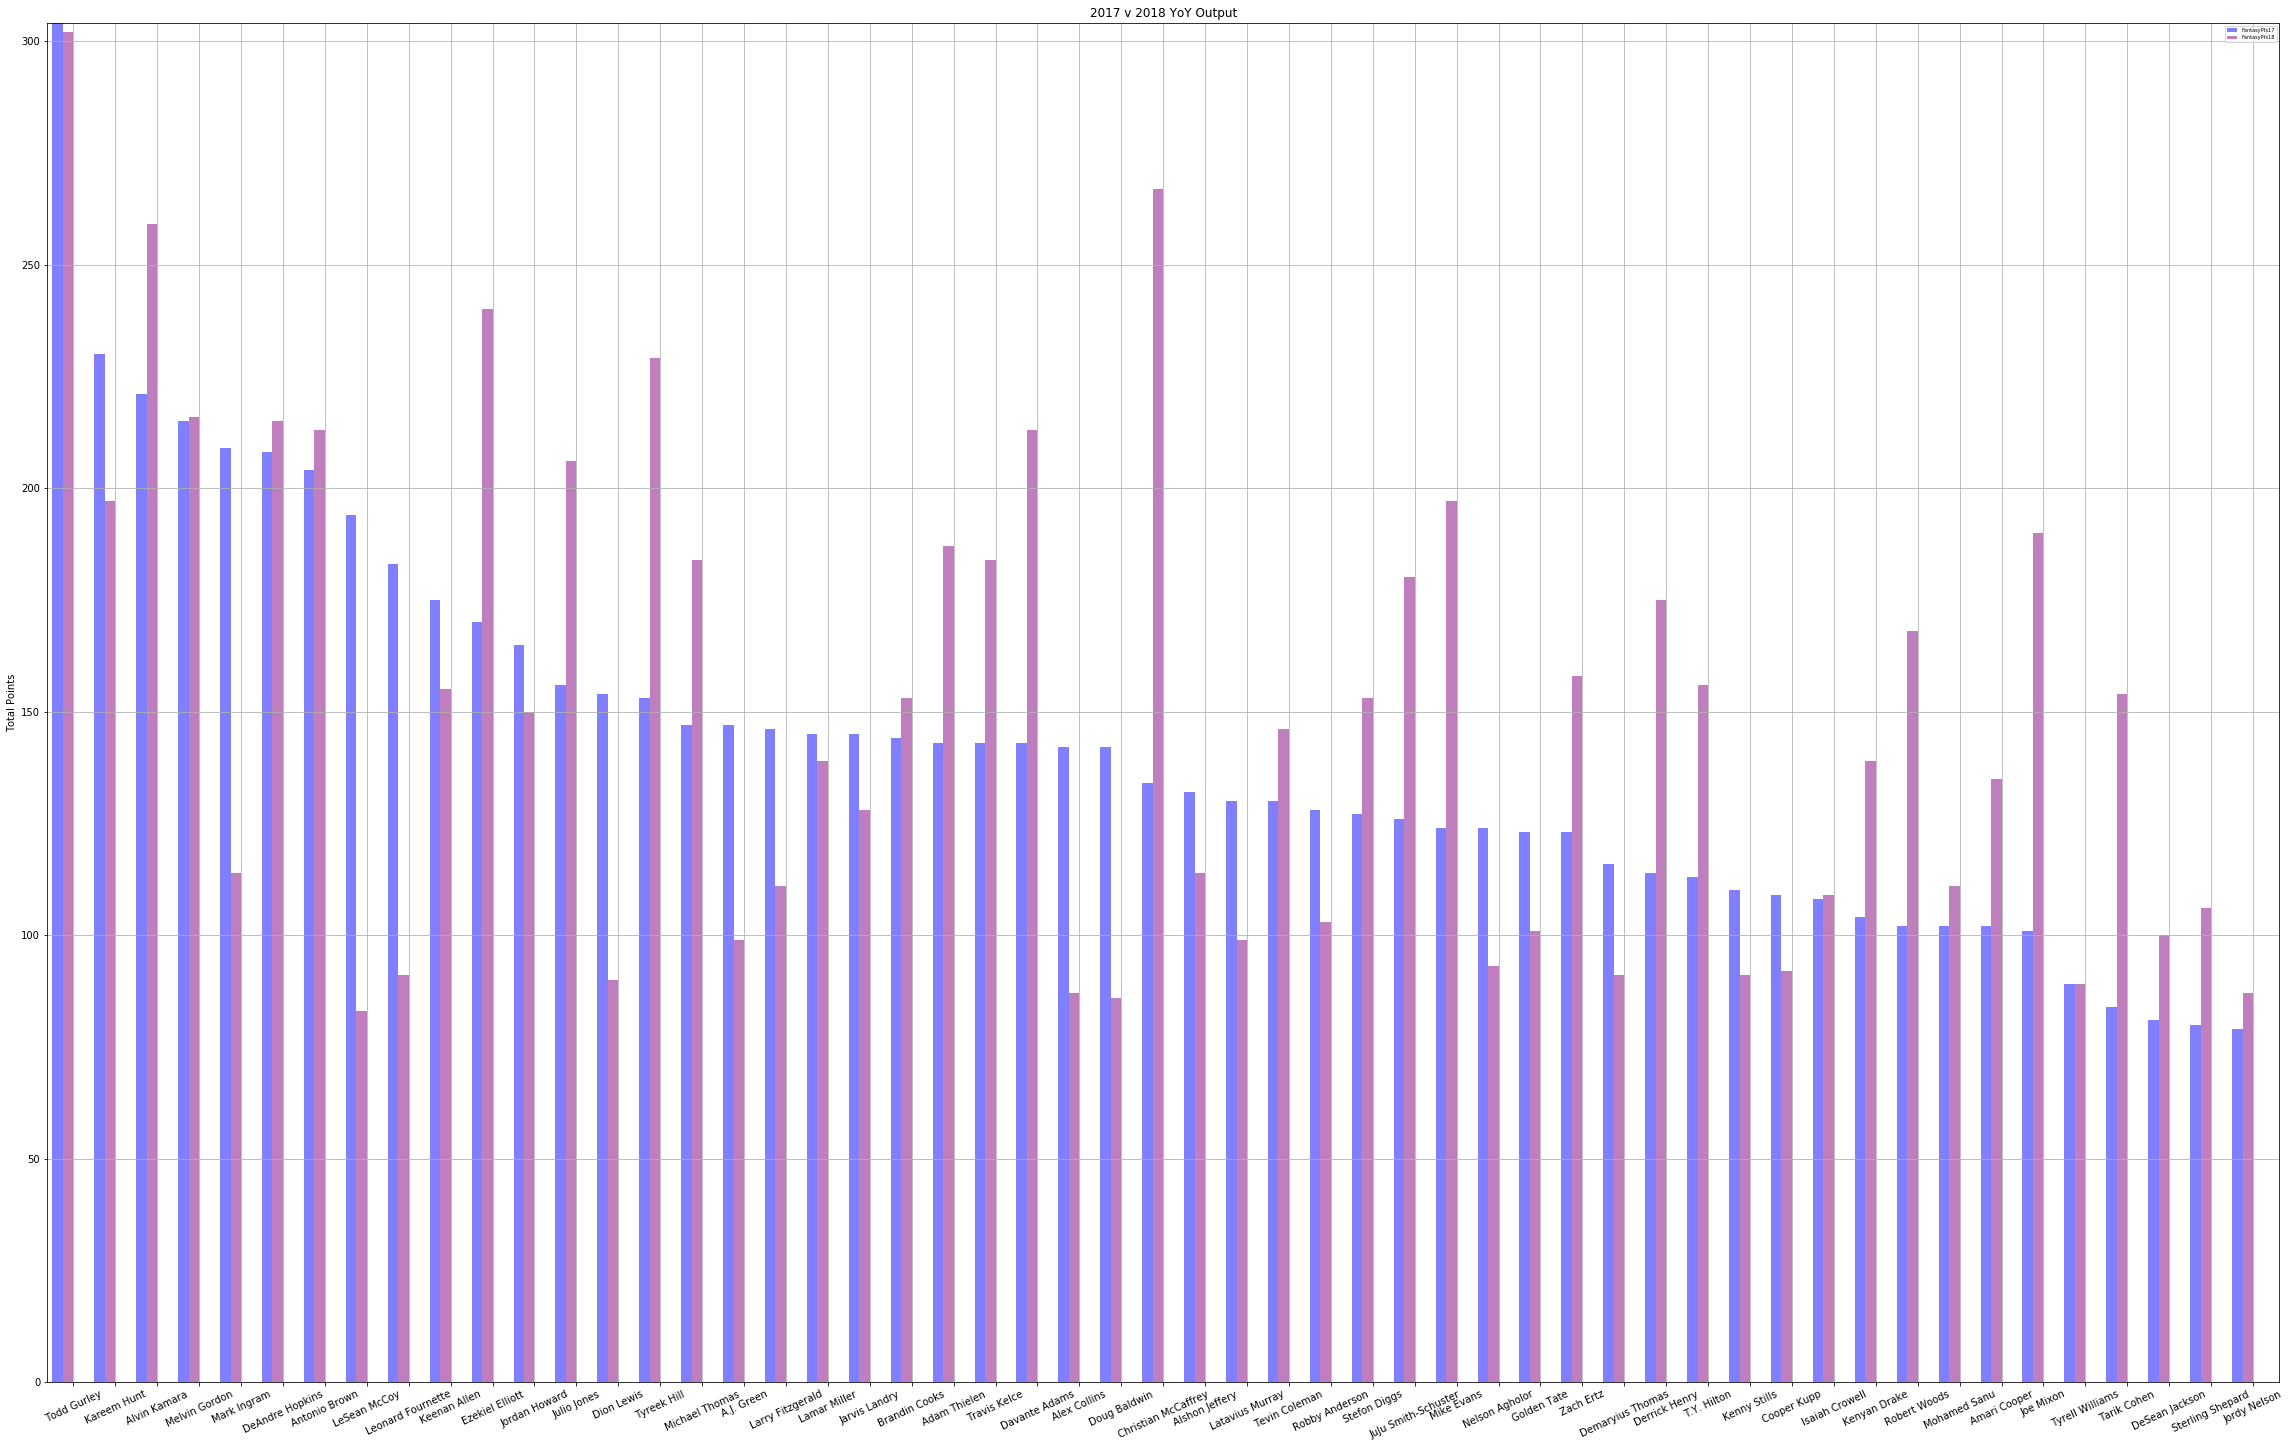

In [853]:
pos = list(range(len(df_join_plot['FantasyPts17']))) 
width = .25
    
fig, ax = plt.subplots(figsize=(40,25))
plt.bar(pos,df_join_plot['FantasyPts17'],width, alpha=0.5,color='blue', label=df_join_plot['Player'][0])

plt.bar([p + width for p in pos], df_join_plot['FantasyPts18'], width, alpha=0.5, color='purple', 
        label=df_join_plot['Player'][1]) 

ax.set_ylabel('Total Points')
ax.set_title('2017 v 2018 YoY Output')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df_join_plot['Player'])

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df_join_plot['FantasyPts17'] )] )
plt.rcParams.update({'font.size': 5})
plt.xticks(rotation=25)

plt.legend(['FantasyPts17', 'FantasyPts18'], loc='upper right')
plt.grid()
plt.show()

In [854]:
df_join_2 = pd.merge(df2, df3, how='inner', on='Player')
df_join_plot2 = df_join_2

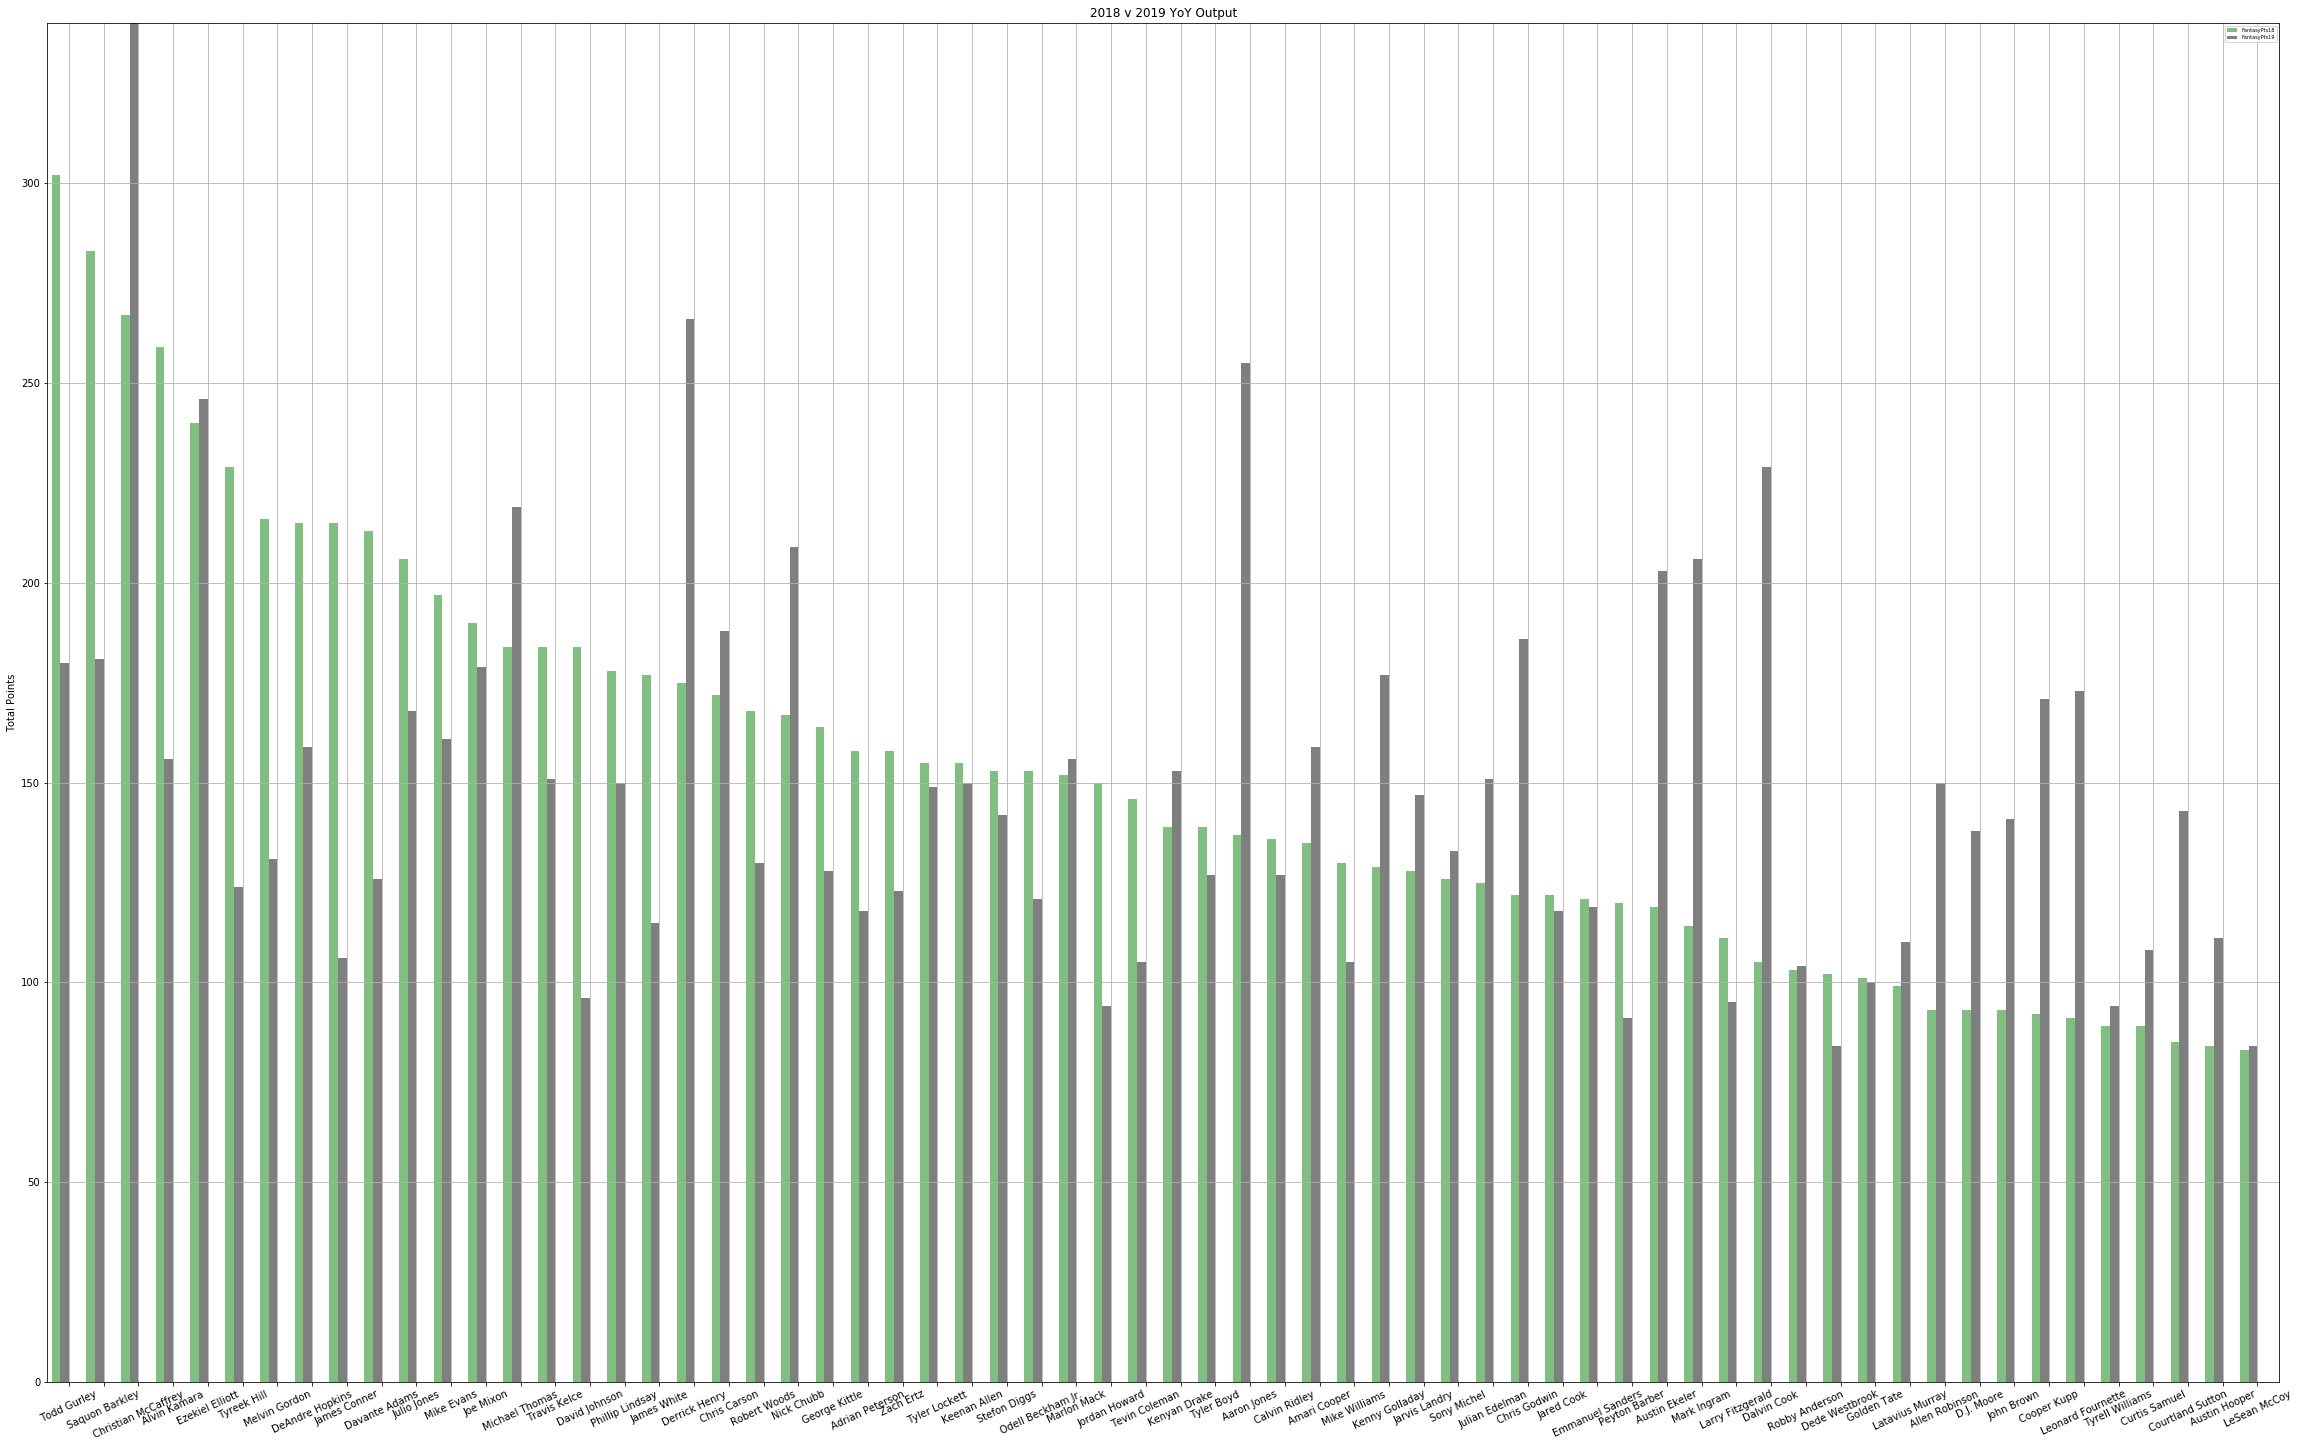

In [866]:
pos = list(range(len(df_join_plot2['FantasyPts18']))) 
width = .25
    
fig, ax = plt.subplots(figsize=(40,25))
plt.bar(pos,df_join_plot2['FantasyPts18'],width, alpha=0.5,color='green', label=df_join_plot2['Player'][0])

plt.bar([p + width for p in pos], df_join_plot2['FantasyPts19'], width, alpha=0.5, color='black', 
        label=df_join_plot2['Player'][1]) 

ax.set_ylabel('Total Points')
ax.set_title('2018 v 2019 YoY Output')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df_join_plot2['Player'])

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df_join_plot2['FantasyPts19'] )] )
plt.rcParams.update({'font.size': 5})
plt.xticks(rotation=25)

plt.legend(['FantasyPts18', 'FantasyPts19'], loc='upper right')
plt.grid()
plt.show()

Now that we have some great visualizations to see the increase and decline YoY for players, lets do as we did before and create lists based off, what I would deem, important things to note for our draft boards.

In [856]:
df_join_final = pd.merge(df1, df_join_2, how='inner', on='Player')

In [857]:
df_join_final['Single Season Production Increase'] = (df_join_final['FantasyPts19'] > df_join_final['FantasyPts18'])
inc_prod_1 = (df_join_final.loc[df_join_final['Single Season Production Increase'].isin([True])])
inc_prod_1['Player']

3             Mark Ingram
5            LeSean McCoy
6       Leonard Fournette
8         Ezekiel Elliott
12         Michael Thomas
14          Jarvis Landry
17    Christian McCaffrey
18        Latavius Murray
20         Robby Anderson
25          Derrick Henry
26            Cooper Kupp
27           Kenyan Drake
29           Amari Cooper
31        Tyrell Williams
Name: Player, dtype: object

In [870]:
df_join_final['Increased Production Each Year'] = (df_join_final['FantasyPts19'] > df_join_final['FantasyPts18']) & (df_join_final['FantasyPts18'] > df_join_final['FantasyPts17'])
inc_prod = (df_join_final.loc[df_join_final['Increased Production Each Year'].isin([True])])
inc_prod['Player']

8         Ezekiel Elliott
12         Michael Thomas
17    Christian McCaffrey
25          Derrick Henry
27           Kenyan Drake
29           Amari Cooper
Name: Player, dtype: object

In [871]:
df_join_final['Decreased Production Each Year'] = (df_join_final['FantasyPts19'] < df_join_final['FantasyPts18']) & (df_join_final['FantasyPts18'] < df_join_final['FantasyPts17'])
dec_prod = (df_join_final.loc[df_join_final['Decreased Production Each Year'].isin([True])])
dec_prod['Player']

0          Todd Gurley
7         Keenan Allen
9        Jordan Howard
13    Larry Fitzgerald
23         Golden Tate
Name: Player, dtype: object

So now we have a couple lists of players who have fully grown each year in their fantasy outputs, we'll call these High Priority Targets, and also those who have decreased each season, those will be Red Flag Players. Keep in mind players like Todd Gurley and Jordan Howard are getting second chances on new teams, but based on strictly fantasy output you'll want to make your decisions on drafting these players with this info in mind (High risk doesn't always equal High reward).

There is a lot to digest here, but whats great is we can now see who has stayed consistant, who has continued to regress and who has continually grown their fantasy output YoY. This can be used as another piece in building our pre-draft boards for the 2020 fantasy football season.

Now that we've gained some better understanding of the data and the positional pieces to take in to consideration, lets start building our algorithm. One thing to note, above was a good dive into the data, but we can absolutely take this a step further by checking into other variables that can impact all of this, which I may do later on.

## Multiple Linear Regression Algorithm

Now typically the algorithm will auto generate dummies, but for the sake of clear and concise breakdowns I'll do that ahead of time.

In [860]:
df3_dummies = pd.get_dummies(df3.Position, prefix='Position')
df3_final = pd.concat([df3[['Player','FantasyPts19', 'RushingYards19', 'RushingTD19', 'ReceivingYards19', 'ReceivingTDs19']],df3_dummies],axis=1)

In [861]:
df3_final.head(1)

,Player,FantasyPts19,RushingYards19,RushingTD19,ReceivingYards19,ReceivingTDs19,Position_RB,Position_TE,Position_WR
Rank,,,,,,,,,
1,Christian McCaffrey,340,1387,15,1005,4,1,0,0


In [862]:
points_predict = sm.ols("FantasyPts19 ~ RushingYards19 + RushingTD19 + ReceivingYards19 + ReceivingTDs19 + Position_RB + Position_WR", data=df3_final).fit() 
points_predict.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FantasyPts19   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4654.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):          6.15e-113
Time:                        21:39:08   Log-Likelihood:                -234.23
No. Observations:                 100   AIC:                             482.5
Df Residuals:                      93   BIC:                             500.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.8295      1.456     -3.318      0.001      -7.720      -1.939
RushingYards19       0.0966      0.002     55.048      0.000       0.093       0.100
RushingTD19          6.0397      0.144     41.860      0.000       5.753       6.326
ReceivingYards19     0.0971      0.001     75.569      0.000       0.095       0.100
ReceivingTDs19       6.1313      0.149     41.155      0.000       5.835       6.427
Position_RB         -4.2265      1.594     -2.651      0.009      -7.393      -1.060
Position_WR          0.7107      0.949      0.749      0.456      -1.173       2.594
==============================================================================
Omnibus:                        4.972   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                4.843
Skew:                           0.331   Prob(JB):                       0.0888
Kurtosis:                       3.850   Cond. No.                     6.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we can see that WR's actually hurt the model here when breaking apart the positions, which does makes sense as the RB position (as seen in our exploratory analysis) is the strongest fantasy position. So what we could/should do is actually build out a few models strictly based on position datasets with this linear regression algorithm, but since its building a full draft board inclusive of all positions, that may actually end up being pernicious in the long haul. 

One thing to note, the TE position was omitted due to the slightly technical issue of multicollinearity. If all 3 categories were converted to dummy variables, then the sum of the 3 dummy variables would always be 1. If some combination of variables adds up to a constant, then there is no solution to the linear regression problem (this is only true when our regression formula includes a constant term, but for our purposes it always will). So statsmodels chooses a class to serve as a reference class

In [863]:
points_predict = sm.ols("FantasyPts19 ~ RushingYards19 + RushingTD19 + ReceivingYards19 + ReceivingTDs19 + Position_RB", data=df3_final).fit() 
points_predict.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FantasyPts19   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5611.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):          1.03e-114
Time:                        21:39:09   Log-Likelihood:                -234.53
No. Observations:                 100   AIC:                             481.1
Df Residuals:                      94   BIC:                             496.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.2574      1.236     -3.443      0.001      -6.712      -1.802
RushingYards19       0.0966      0.002     55.198      0.000       0.093       0.100
RushingTD19          6.0377      0.144     41.951      0.000       5.752       6.323
ReceivingYards19     0.0972      0.001     76.002      0.000       0.095       0.100
ReceivingTDs19       6.1253      0.148     41.271      0.000       5.831       6.420
Position_RB         -4.8162      1.383     -3.481      0.001      -7.563      -2.069
==============================================================================
Omnibus:                        5.678   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.640
Skew:                           0.376   Prob(JB):                       0.0596
Kurtosis:                       3.888   Cond. No.                     5.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [864]:
fantasy_points_predictor = pd.DataFrame({'RushingYards19': [800, 1050, 250, -8, 906, 1278], 'RushingTD19': [4, 7, 2, 3, 5, 13], 
                                  'ReceivingYards19': [256, 150, 680, 700, 587, 357],'ReceivingTDs19': [5, 2, 6, 3, 8, 7]
                                  ,'Position_RB': [1, 1, 0, 0, 1, 1]})
fantasy_points_predictor['Predicted'] = points_predict.predict(new_fantasy_points)
fantasy_points_predictor

,RushingYards19,RushingTD19,ReceivingYards19,ReceivingTDs19,Position_RB,Predicted
0,800,4,256,5,1,147.865543
1,1050,7,150,2,1,161.454723
2,250,2,680,6,0,134.797714
3,-8,3,700,3,0,99.478225
4,906,5,587,8,1,214.683008
5,1278,13,357,7,1,270.448186


The above is just a breakdown of letting us predict new values given new or hypothetical data.

So we have created a basic algorithm to predict our fantasy point outcomes based on these factors, and with some external factors alonside machine learning to help us determine these stats (rushing yards, rushing tds, receiving yards, rec tds etc.) we can fit our model to check the predicted outcome to help us draft! Note that we can continue to better this model by fitting other features, but this is the start for this project. 

For now I am going to leave this, but I would like to take it a step further into trying a few other machine learning techniques as well as trying complete position splits for each algorithm. One last thing would be preparing a better YoY breakdown for the model, so we can see how much impact multiple years have on the output (adding in 2017 & 2018 stats for each player).